In [89]:
from __future__ import division
import numpy as np
from scipy.integrate import odeint

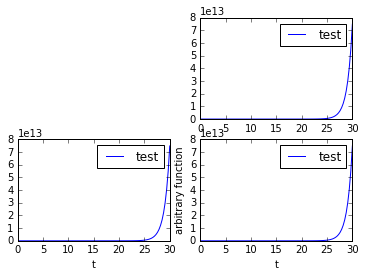

In [122]:
def test_torque(t):
    return t*2

def test_model(y, t):
    dy = y[0] + test_torque(t)
    return [dy]

t = np.linspace(0.0, 30.0, 100)
y_init = np.array([5.0])
y = odeint(test_model, y_init, t)

plot.figure(1)

plot.subplot(222)
plot.plot(t, y[:,0], label="test")
plot.xlabel("time")
plot.legend()

plot.subplot(223)
plot.plot(t, y[:,0], label="test")
plot.xlabel("t")
plot.legend()

plot.subplot(224)
plot.plot(t, y[:,0], label="test")
plot.xlabel("t")
plot.ylabel("arbitrary function")
plot.legend()

plot.show()

Integration successful.
[  0.00000000e+00   6.03866952e+00   2.41546780e+01   5.43480255e+01
   9.66187120e+01   1.50966737e+02   2.17392102e+02   2.95894805e+02
   3.86474848e+02   4.89132229e+02   6.03866950e+02   7.30679009e+02
   8.69568408e+02   1.02053515e+03   1.18357922e+03   1.35870064e+03
   1.54589939e+03   1.74517548e+03   1.95652892e+03   2.17995969e+03
   2.41546780e+03   2.66305325e+03   2.92271604e+03   3.19445616e+03
   3.47827363e+03   3.77416844e+03   4.08214058e+03   4.40219006e+03
   4.73431689e+03   5.07852105e+03   5.43480255e+03   5.80316139e+03
   6.18359757e+03   6.57611108e+03   6.98070194e+03   7.39737013e+03
   7.82611567e+03   8.26693854e+03   8.71983875e+03   9.18481631e+03
   9.66187120e+03   1.01510034e+04   1.06522130e+04   1.11654999e+04
   1.16908641e+04   1.22283057e+04   1.27778247e+04   1.33394209e+04
   1.39130945e+04   1.44988455e+04   1.50966737e+04   1.57065794e+04
   1.63285623e+04   1.69626226e+04   1.76087603e+04   1.82669752e+04
   1.89372

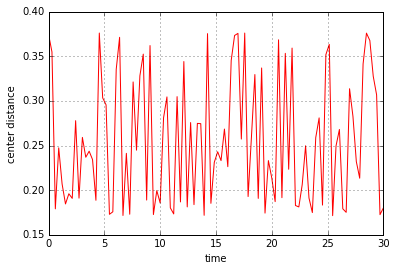

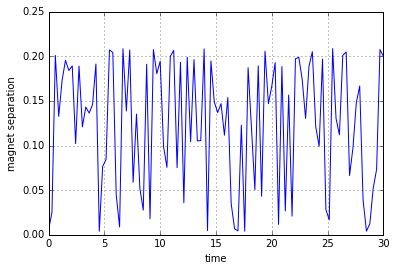

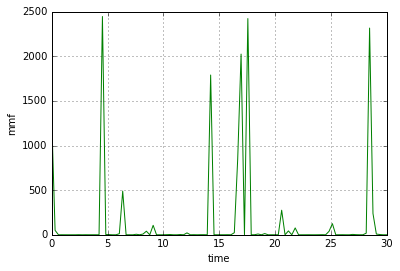

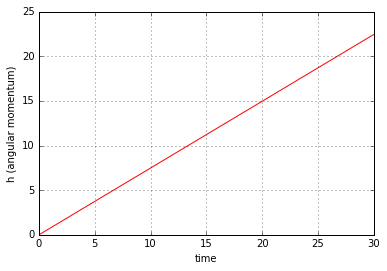

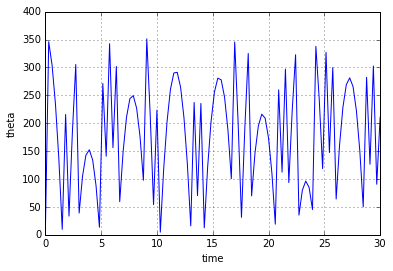

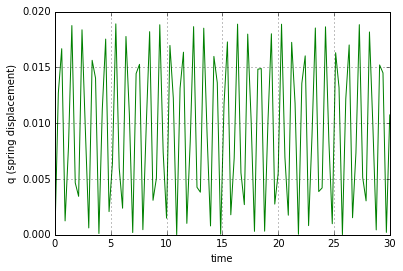

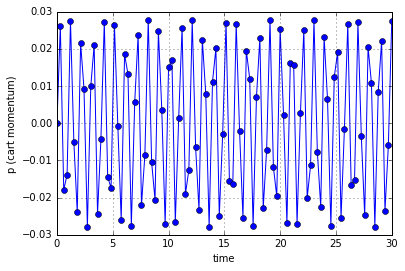

In [188]:
import pdb

# CONSTANTS
wheel_radius = 0.13 # m 
mag_mass = 0.1133981 # kg - home depot reference
cart_mass = 0.175 - mag_mass # kg
spring_const = 400 # N/m => kg/s^2
inertial_mass = 0.5*0.673*wheel_radius**2 # 1/2*wheel_mass*wheel_radius^2
pin_dist = 0.1 # m - distance from center of wheel to rigid arm pin
ra_length = 0.28 # m - length of the rigid arm
rail_height = 0.055 # m - vertical distance from the rail to the center of the wheel

uncompressed_spring_length = 0.05 # m

# MMF specifics
u0 = 4*np.pi*10**-7 # permeability of free space
mag_length = 0.047 # m 
mag_width = 0.022 # m
mag_height = 0.011 # m
mag_radius = mag_height/2 # m - halved height; decide whether this is appropriate
pole_area = mag_length * mag_width # m^2
mag2_dist = ra_length + 0.1 # m - horizontal distance from center of wheel to second magnet (initial)

# INPUT FUNCTIONS
def input_torque(t):
    """
        input torque as a function of time.
    
        Parameters
        ----------
        t : {numpy array}
            timeseries with appropriate range
    """
    # TODO : define an equation for the input torque
    # use arbitrary torque value and define number of seconds for which the same torque is applied
    # remaining time will have 0 torque
    return 1.0

def mag_force(theta, show_plots=False):
    """
        repelling force as a function of distance between the two magnets.
        distance between magnets is function of theta.
        
        Parameters
        ----------
        theta : {float} or {numpy.array}
            value of theta at an instantaneous time; if plot=True then this is assumed to be a vector
            of theta values over a given period of time

        show_plots : {bool}, optional
            assumes that theta is passed as vector and thus all corresponding values (e.g. center distance,
            force) are vectors to be plotted against time vector (t)
    """ 
    # compute L - distance from the center of the wheel to the first magnet
    center_dist = pin_dist * np.cos(theta) + \
        np.sqrt(ra_length**2 - (rail_height + pin_dist * np.sin(theta))**2)
        
    # separation between magnets
    sep = mag2_dist - center_dist
    
    # store intermediary caclculations for b0 - cleanliness
    inter = [mag_length*mag_width, mag_length**2, mag_width**2, mag_height + sep]
    
    # magnetic flux density calculation - function of separation
    # need to obtain Br (remenance field val)
    # b0 = br/np.pi * (np.arctan(inter[0]/(2*sep*np.sqrt(4*sep**2 + inter[1] + inter[2]))) - \
    #                  np.arctan(inter[0]/(2*inter[3]*np.sqrt(4*inter[3]**2 + inter[1] + inter[2]))))
    
    b0 = 3800/10**4
    
    # print (b0**2 * pole_area**2 * (mag_length**2 + mag_radius**2))/(np.pi*u0 * mag_length**2)
    
    # print 1/sep**2 + 1/(sep + 2*mag_length)**2 - 2/(sep + mag_length)**2
    
    # magnetomotive force - assumes cylindrical bar magnets
    force = ((b0**2 * pole_area**2 * (mag_length**2 + mag_radius**2))/(np.pi*u0 * mag_length**2)) * \
        (1/sep**2 + 1/(sep + 2*mag_length)**2 - 2/(sep + mag_length)**2)
        
        
    if show_plots:    
        # plot center distance, separation, and mmf
        plot.plot(t, center_dist, "r-")
        plot.ylabel("center distance")
        plot.xlabel("time")
        plot.grid()
        plot.show()

        plot.plot(t, sep)
        plot.ylabel("magnet separation")
        plot.xlabel("time")
        plot.grid()
        plot.show()


        plot.plot(t, force, "g-")
        plot.ylabel("mmf")
        plot.xlabel("time")
        plot.grid()
        plot.show()
    
    return force

# SIMULATION
def model_1(y, t):
    """
        generate series of RHS equations from system 1 to be passed
        into solver.
        
        Parameters
        ----------
        y : {numpy.array}
            initial conditions for system
        
        t : {numpy.array}
            timeseries with appropriate range
    """
    p2 = y[0]
    
    dp2 = input_torque(t) / (1 + (wheel_radius**2)*mag_mass/inertial_mass)
    dtheta = p2/inertial_mass
    
    return [dp2, dtheta]
    
def model_2(y, t, theta):
    """
        generate series of RHS equations from system 2 to be passed
        into solver.

        Parameters
        ----------
        y : {numpy.array}
            initial conditions for system

        t : {numpy.array}
            timeseries with appropriate range
    """
    q8 = y[0]
    p7 = y[1]
    
    dp7 = (mag_force(70) - q8 * spring_const)/(1 + mag_mass/cart_mass)
    dq8 = p7/cart_mass

    return [dq8, dp7]

def simulate():
    # initial conditions
    p2_0 = 0.0 # angular momentum (2)
    q8_0 = 0.0 # spring displacement (8)
    p7_0 = 0.0 # momentum (7)
    theta_0 = 0.0 # init angle

    time = np.linspace(0.0, 30.0, 100) # 100 points between 0 and 30 seconds

    """
        We compute angular momentum and theta first as we've split the two
        systems and because the magnetomotive repelling force is a function
        of theta.
    """
    y_init_1 = [p2_0, theta_0]

    # angular momentum and theta
    y1 = odeint(model_1, y_init_1, time, printmessg=True)

    p2 = y1[:,0]
    
    theta = np.degrees(y1[:,1])
    
    theta = map(lambda x: x % 360, theta)

    y_init_2 = [q8_0, p7_0]

    # spring displacement and cart momentum
    extra_args = (theta,)

    y2 = odeint(model_2, y_init_2, time, args=extra_args, printmessg=True)

    q8 = y2[:,0]
    p7 = y2[:,1]

    # compute and plot theta-related values
    mag_force(theta, show_plots=True)

    # plot all output variables over time
    plot.plot(t, p2, "r-")
    plot.xlabel("time")
    plot.ylabel("h (angular momentum)")
    plot.legend()
    plot.grid()
    plot.show()

    plot.plot(t, theta)
    plot.xlabel("time")
    plot.ylabel("theta")
    plot.grid()
    plot.show()

    plot.plot(t, q8, "g-")
    plot.xlabel("time")
    plot.ylabel("q (spring displacement)")
    plot.grid()
    plot.show()

    plot.plot(t, p7, "o-")
    plot.xlabel("time")
    plot.ylabel("p (cart momentum)")
    plot.grid()
    plot.show()

simulate()

In [128]:
# placeholder

Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.


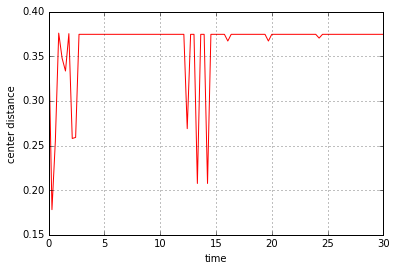

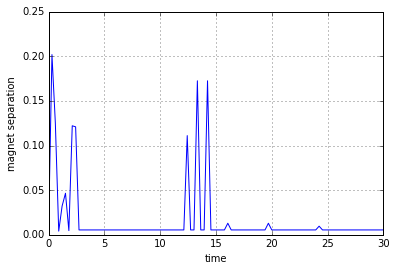

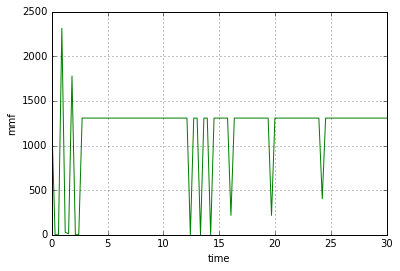

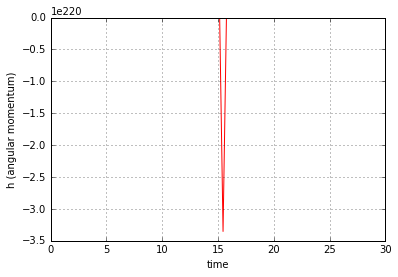

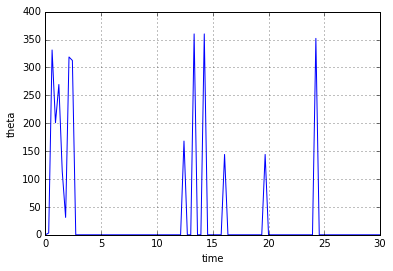

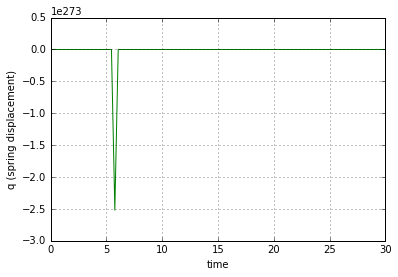

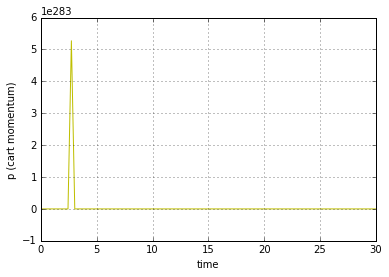

In [190]:
import pdb

from math import sin, cos

# CONSTANTS
wheel_radius = 0.13 # m 
mag_mass = 0.1133981 # kg - home depot reference
cart_mass = 0.175 - mag_mass # kg
spring_const = 400 # N/m => kg/s^2
inertial_mass = 0.5*0.673*wheel_radius**2 # 1/2*wheel_mass*wheel_radius^2
pin_dist = 0.1 # m - distance from center of wheel to rigid arm pin
ra_length = 0.28 # m - length of the rigid arm
rail_height = 0.055 # m - vertical distance from the rail to the center of the wheel

uncompressed_spring_length = 0.05 # m

# MMF specifics
u0 = 4*np.pi*10**-7 # permeability of free space
mag_length = 0.047 # m 
mag_width = 0.022 # m
mag_height = 0.011 # m
mag_radius = mag_height/2 # m - halved height; decide whether this is appropriate
pole_area = mag_length * mag_width # m^2
mag2_dist = ra_length + 0.1 # m - horizontal distance from center of wheel to second magnet (initial)

# INPUT FUNCTIONS
def input_torque(t):
    """
        input torque as a function of time.
    
        Parameters
        ----------
        t : {numpy array}
            timeseries with appropriate range
    """
    # TODO : define an equation for the input torque
    # use arbitrary torque value and define number of seconds for which the same torque is applied
    # remaining time will have 0 torque
    
    return 7.0*inertial_mass - 0.3*t

def mag_force(theta, show_plots=False):
    """
        repelling force as a function of distance between the two magnets.
        distance between magnets is function of theta.
        
        Parameters
        ----------
        theta : {float} or {numpy.array}
            value of theta at an instantaneous time; if plot=True then this is assumed to be a vector
            of theta values over a given period of time

        show_plots : {bool}, optional
            assumes that theta is passed as vector and thus all corresponding values (e.g. center distance,
            force) are vectors to be plotted against time vector (t)
    """ 
    # compute L - distance from the center of the wheel to the first magnet
    center_dist = pin_dist * np.cos(theta) + \
        np.sqrt(ra_length**2 - (rail_height + pin_dist * np.sin(theta))**2)
        
    # separation between magnets
    sep = mag2_dist - center_dist
    
    # store intermediary caclculations for b0 - cleanliness
    inter = [mag_length*mag_width, mag_length**2, mag_width**2, mag_height + sep]
    
    b0 = 3800/10**4
    
    # print (b0**2 * pole_area**2 * (mag_length**2 + mag_radius**2))/(np.pi*u0 * mag_length**2)
    
    # print 1/sep**2 + 1/(sep + 2*mag_length)**2 - 2/(sep + mag_length)**2
    
    # magnetomotive force - assumes cylindrical bar magnets
    force = ((b0**2 * pole_area**2 * (mag_length**2 + mag_radius**2))/(np.pi*u0 * mag_length**2)) * \
        (1/sep**2 + 1/(sep + 2*mag_length)**2 - 2/(sep + mag_length)**2)
        
        
    if show_plots:    
        # plot center distance, separation, and mmf
        plot.plot(t, center_dist, "r-")
        plot.ylabel("center distance")
        plot.xlabel("time")
        plot.grid()
        plot.show()

        plot.plot(t, sep)
        plot.ylabel("magnet separation")
        plot.xlabel("time")
        plot.grid()
        plot.show()

        plot.plot(t, force, "g-")
        plot.ylabel("mmf")
        plot.xlabel("time")
        plot.grid()
        plot.show()
    
    return force

# SIMULATION
def model(y, t):
    p2, theta, q8, p7 = y
    
    dp2 = input_torque(t) / (1 + (wheel_radius**2)*mag_mass/inertial_mass)
    dtheta = p2/inertial_mass
    dp7 = (mag_force(theta) - q8*spring_const)/(1 + mag_mass/cart_mass)
    dq8 = p7/cart_mass
    
    return [dp2, dtheta, dq8, dp7]

def simulate():
    # initial conditions
    p2_0 = 0.0 # angular momentum (2)
    q8_0 = 0.0 # spring displacement (8)
    p7_0 = 0.0 # momentum (7)
    theta_0 = 0.0 # init angle

    time = np.linspace(0.0, 30.0, 100) # 100 points between 0 and 30 seconds

    y_init = [p2_0, theta_0, q8_0, p7_0]
    
    y = odeint(model, y_init, time, printmessg=True)    
    
    p2 = y[:, 0]
    theta = y[:, 1]
    q8 = y[:, 2]
    p7 = y[:, 3]
    
    theta = map(lambda x: x % 360, np.degrees(theta))
    
    # compute and plot theta-related values
    mag_force(theta, show_plots=True)

    # plot all output variables over time
    plot.plot(t, p2, "r-")
    plot.xlabel("time")
    plot.ylabel("h (angular momentum)")
    plot.legend()
    plot.grid()
    plot.show()
    
    # convert theta to degrees before plotting
    plot.plot(t, theta)
    plot.xlabel("time")
    plot.ylabel("theta")
    plot.grid()
    plot.show()

    plot.plot(t, q8, "g-")
    plot.xlabel("time")
    plot.ylabel("q (spring displacement)")
    plot.grid()
    plot.show()

    plot.plot(t, p7, "y")
    plot.xlabel("time")
    plot.ylabel("p (cart momentum)")
    plot.grid()
    plot.show()

simulate()

In [ ]:
# placeholder